## [Can Supervised ML Classifiers Improve ROI of Pairs Trading?](https://python.plainenglish.io/can-supervised-ml-classifiers-improve-roi-of-pairs-trading-1a6e1a1f9711)

> Delve into ML-Powered Cointegrated Statistical Arbitrage with Z-Score, Backtesting, Sharpe Ratio and Max Drawdown KPIs in Python

In [1]:
!pip install -q -U yfinance statsmodels

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [3]:
# Download stock data
tickers = ['AAL', 'BBY']
data = yf.download(tickers, start='2020-01-01')['Close']

# Preview the data
data.tail()

/tmp/ipython-input-1659524259.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01')['Close']
[*********************100%***********************]  2 of 2 completed


Ticker,AAL,BBY
Date,,
2025-08-18,13.17,71.800003
2025-08-19,13.22,74.099998
2025-08-20,12.80,72.269997
2025-08-21,12.57,72.389999
2025-08-22,13.55,75.389999


In [4]:
data.describe()

Ticker,AAL,BBY
count,1418.000000,1418.000000
mean,15.377679,77.685525
std,3.979182,13.060424
min,9.040000,41.297646
25%,12.537500,67.679319
50%,14.380000,74.626305
75%,17.350000,87.799255
max,30.469999,116.561325


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1418 entries, 2020-01-02 to 2025-08-22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAL     1418 non-null   float64
 1   BBY     1418 non-null   float64
dtypes: float64(2)
memory usage: 33.2 KB


In [6]:
data.shape

(1418, 2)

In [7]:
data.head()

Ticker,AAL,BBY
Date,,
2020-01-02,28.982893,70.483734
2020-01-03,27.548195,70.378792
2020-01-06,27.219410,70.968109
2020-01-07,27.119778,71.371735
2020-01-08,27.737495,71.565506


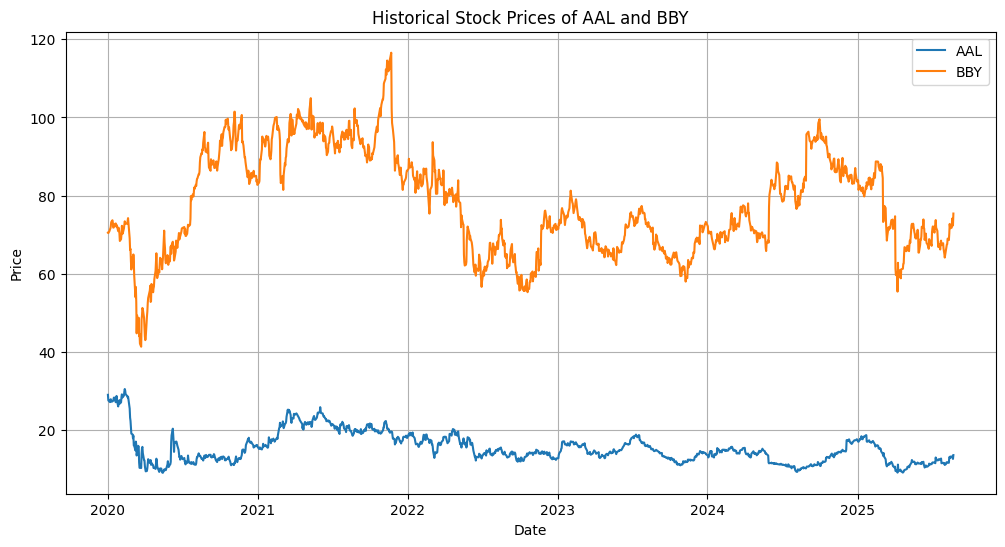

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data['AAL'], label='AAL')
plt.plot(data['BBY'], label='BBY')
plt.title('Historical Stock Prices of AAL and BBY')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [9]:
score, p_value, _ = coint(data['AAL'], data['BBY'])

print(f'Cointegration test p-value: {p_value}')

# If p-value is low (<0.05), the pairs are cointegrated
if p_value < 0.05:
    print("The pairs are cointegrated.")
else:
    print("The pairs are not cointegrated.")

Cointegration test p-value: 0.006166834353612271
The pairs are cointegrated.


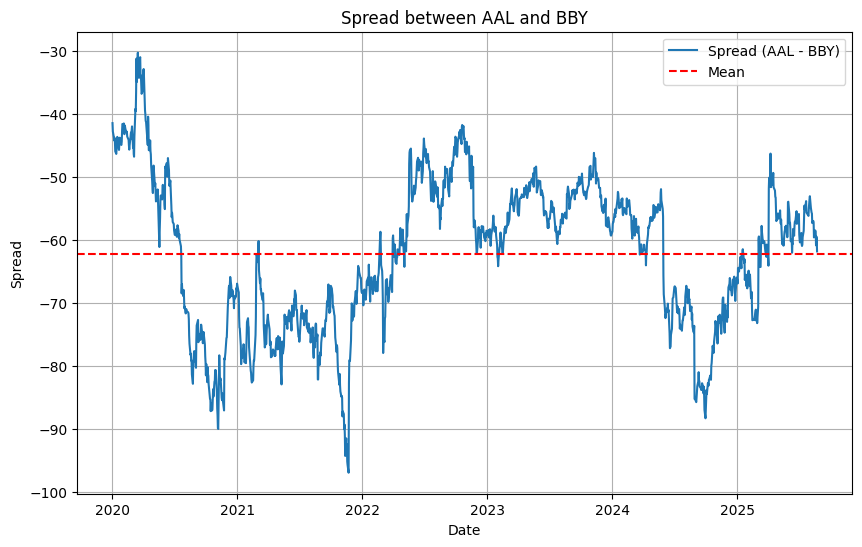

In [10]:
data['Spread'] = data['AAL'] - data['BBY']

# Plot the spread
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Spread'], label='Spread (AAL - BBY)')
plt.axhline(data['Spread'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Spread between AAL and BBY')
plt.grid()
plt.show()

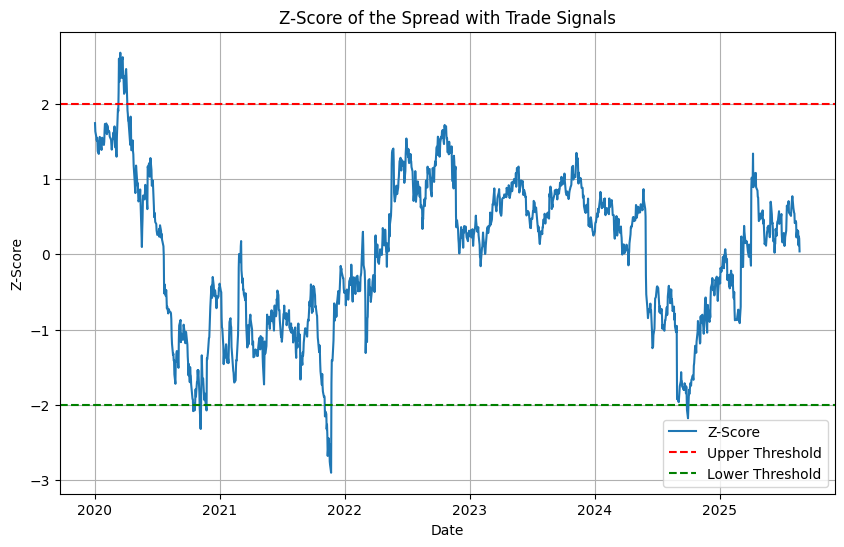

In [11]:
# Define z-score to normalize the spread
data['Z-Score'] = (data['Spread'] - data['Spread'].mean()) / data['Spread'].std()

# Set thresholds for entering and exiting trades
upper_threshold = 2
lower_threshold = -2

# Initialize signals
data['Position'] = 0

# Generate signals for long and short positions
data['Position'] = np.where(data['Z-Score'] > upper_threshold, -1, data['Position'])  # Short the spread
data['Position'] = np.where(data['Z-Score'] < lower_threshold, 1, data['Position'])   # Long the spread
data['Position'] = np.where((data['Z-Score'] < 1) & (data['Z-Score'] > -1), 0, data['Position'])  # Exit

# Plot z-score and positions
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Z-Score'], label='Z-Score')
plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
plt.legend()
plt.title('Z-Score of the Spread with Trade Signals')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.grid()
plt.show()

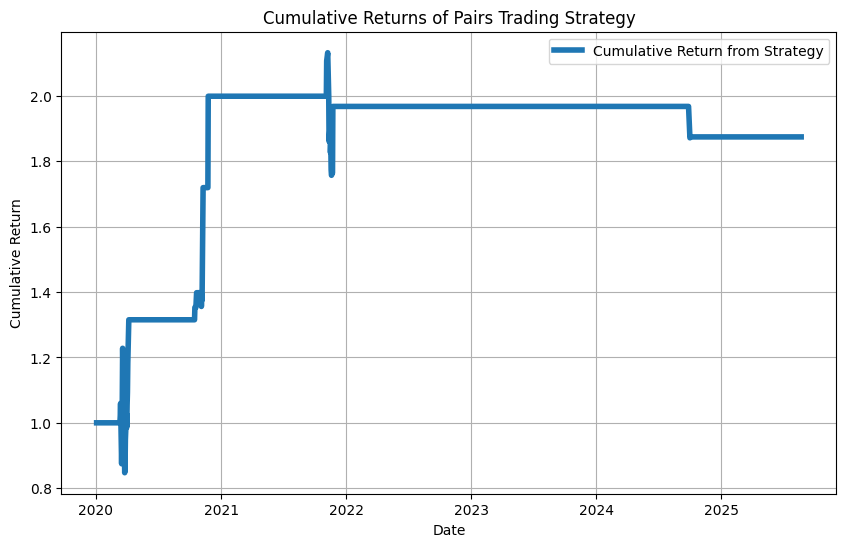

In [12]:
# Calculate daily returns
data['AAL_Return'] = data['AAL'].pct_change()
data['BBY_Return'] = data['BBY'].pct_change()

# Strategy returns: long spread means buying PEP and shorting KO
data['Strategy_Return'] = data['Position'].shift(1) * (data['AAL_Return'] - data['BBY_Return'])

# Cumulative returns
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Cumulative_Return'], label='Cumulative Return from Strategy',lw=4)
plt.title('Cumulative Returns of Pairs Trading Strategy')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid()
plt.show()

In [13]:
# Calculate Sharpe Ratio
sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calculate max drawdown
cumulative_max = data['Cumulative_Return'].cummax()
drawdown = (cumulative_max - data['Cumulative_Return']) / cumulative_max
max_drawdown = drawdown.max()
print(f'Max Drawdown: {max_drawdown}')

Sharpe Ratio: 0.6017785363773396
Max Drawdown: 0.30985465495395786


In [14]:
data['AAL_Return']=data['AAL_Return'].fillna(0)
data['BBY_Return']=data['BBY_Return'].fillna(0)
data['Cumulative_Return']=data['Cumulative_Return'].fillna(0)
data['Strategy_Return']=data['Cumulative_Return'].fillna(0)

data.head()

Ticker,AAL,BBY,Spread,Z-Score,Position,AAL_Return,BBY_Return,Strategy_Return,Cumulative_Return
Date,,,,,,,,,
2020-01-02,28.982893,70.483734,-41.500841,1.743541,0,0.000000,0.000000,0.0,0.0
2020-01-03,27.548195,70.378792,-42.830597,1.632113,0,-0.049502,-0.001489,1.0,1.0
2020-01-06,27.219410,70.968109,-43.748699,1.555180,0,-0.011935,0.008374,1.0,1.0
2020-01-07,27.119778,71.371735,-44.251957,1.513009,0,-0.003660,0.005687,1.0,1.0
2020-01-08,27.737495,71.565506,-43.828011,1.548534,0,0.022777,0.002715,1.0,1.0


In [15]:
X = data[['AAL_Return', 'BBY_Return']]
y = data['Position']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
predictions = rf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy of the Random Forest Classifier: {accuracy}')

Accuracy of the Random Forest Classifier: 0.9647887323943662


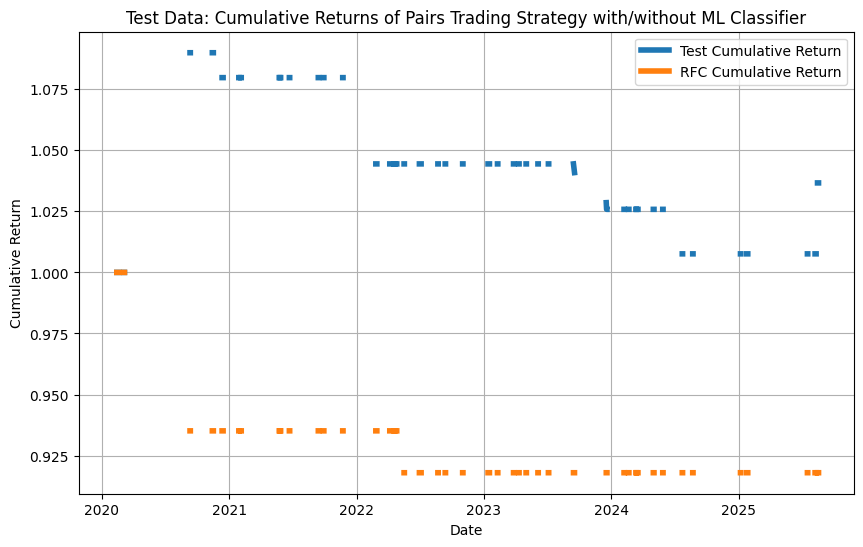

In [18]:
s = pd.Series(predictions, index=y_test.index)

data['Test_Return'] = y_test.shift(1) * (data['AAL_Return'] - data['BBY_Return'])
data['RFC_Return'] =s.shift(1) * (data['AAL_Return'] - data['BBY_Return'])

# Cumulative returns
data['Test_Cumulative_Return'] = (1 + data['Test_Return']).cumprod()
data['RFC_Cumulative_Return'] = (1 + data['RFC_Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Test_Cumulative_Return'], label='Test Cumulative Return',lw=4)
plt.plot(data.index, data['RFC_Cumulative_Return'], label='RFC Cumulative Return',lw=4)
plt.title('Test Data: Cumulative Returns of Pairs Trading Strategy with/without ML Classifier')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid()
plt.show()

In [19]:
rf = KNeighborsClassifier(n_neighbors=3)

rf.fit(X_train, y_train)

# Make predictions
predictions = rf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy of KNN: {accuracy}')

Accuracy of KNN: 0.9577464788732394


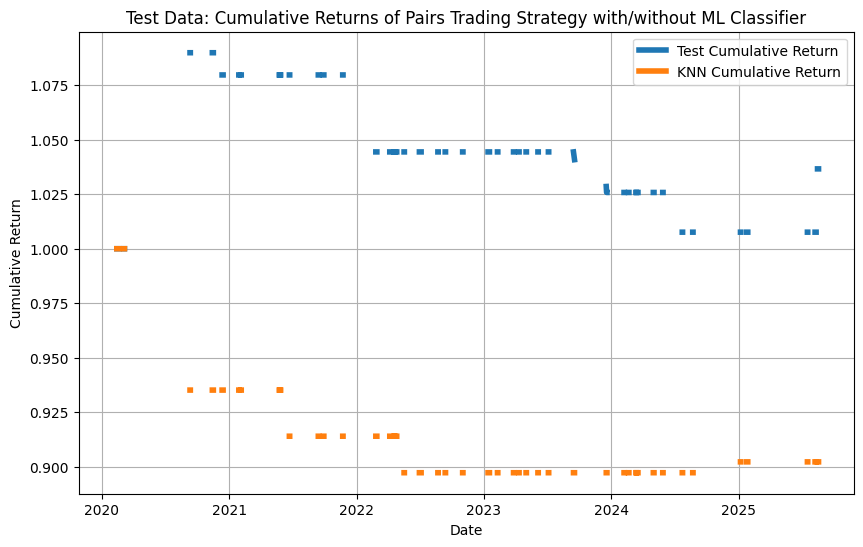

In [20]:
s = pd.Series(predictions, index=y_test.index)

# Strategy returns
data['Test_Return'] = y_test.shift(1) * (data['AAL_Return'] - data['BBY_Return'])
data['KNN_Return'] =s.shift(1) * (data['AAL_Return'] - data['BBY_Return'])

# Cumulative returns
data['Test_Cumulative_Return'] = (1 + data['Test_Return']).cumprod()
data['KNN_Cumulative_Return'] = (1 + data['KNN_Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Test_Cumulative_Return'], label='Test Cumulative Return',lw=4)
plt.plot(data.index, data['KNN_Cumulative_Return'], label='KNN Cumulative Return',lw=4)
plt.title('Test Data: Cumulative Returns of Pairs Trading Strategy with/without ML Classifier')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid()
plt.show()

In [21]:
#Test set without ML

# Calculate Sharpe Ratio
sharpe_ratio = data['Test_Return'].mean() / data['Test_Return'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calculate max drawdown
cumulative_max = data['Test_Cumulative_Return'].cummax()
drawdown = (cumulative_max - data['Test_Cumulative_Return']) / cumulative_max
max_drawdown = drawdown.max()
print(f'Max Drawdown: {max_drawdown}')

Sharpe Ratio: 0.37647765089319185
Max Drawdown: 0.07556762403617184


In [22]:
#Test set with RFC


# Calculate Sharpe Ratio
sharpe_ratio = data['RFC_Return'].mean() / data['RFC_Return'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calculate max drawdown
cumulative_max = data['RFC_Cumulative_Return'].cummax()
drawdown = (cumulative_max - data['RFC_Cumulative_Return']) / cumulative_max
max_drawdown = drawdown.max()
print(f'Max Drawdown: {max_drawdown}')

Sharpe Ratio: -1.165784173338242
Max Drawdown: 0.08203302978088522


In [23]:
#Test set with KNN


# Calculate Sharpe Ratio
sharpe_ratio = data['KNN_Return'].mean() / data['KNN_Return'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calculate max drawdown
cumulative_max = data['KNN_Cumulative_Return'].cummax()
drawdown = (cumulative_max - data['KNN_Cumulative_Return']) / cumulative_max
max_drawdown = drawdown.max()
print(f'Max Drawdown: {max_drawdown}')

Sharpe Ratio: -1.329113949532554
Max Drawdown: 0.1028172616502665
